In [1]:
import glob
import uproot
import pandas as pd
import numpy as np
import awkward as ak
import tensorflow as tf
import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Normalization
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


import utils.tools as tools
import utils.plotting as plotting

import mplhep as cms
import matplotlib.pyplot as plt

cms.style.use("CMS")
plt.rcParams["figure.figsize"] = (7,7)

2024-06-26 17:38:45.690069: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# flags
useEmu = False
useMP = False # bugfix MP MET
useEmu = True if useMP else useEmu
makePlots = True
keepStruct = False
flatSample = False

doFixedRate = True

# NN stuff
# fraction of signal to train on vs check performance
testNN = False
trainNN = True
trainFrac = 0.5
useGPU = False
normLayer = True
scaleData = False

device = 'GPU: 0' if useGPU else 'CPU: 0'

# objects to use in the training
nObj = 4

# L1 threshold to use for efficiencies
l1MetThresh = 50
netMET_thresh = l1MetThresh

# offline threshold to cut rate check to save time
# *** this is not safe for fixed rate efficiency plots!
l1METCutForRate = 0

# filter out all events with puppiMET < this value
puppiMETCut = 0

# define input sums (case sensitive, see branches.py)
inputSums = ['methf', 'ntt']

# define input objects [Jet, EG, Tau] (case sensitive)
inputs = ['Jet']

# files 
# ** Remember to change inputFormat to nano with new files
sigFiles = "/Volumes/home/netmet_zmuD_full/303.root" #"../data/zmuD/zmuD_*.root"
bkgFiles = "/Volumes/home/netmet_zbD_full/303.root" #"../data/zbD/zbD_4.root"

# small test files
#sigFiles = "../data/zmuD_1k.root"
#bkgFiles = "../data/zbD_303.root"

# 2023D nanoAOD on EOS
#sigFiles = "/eos/cms/store/group/dpg_trigger/comm_trigger/L1Trigger/bundocka/netMET/nano/zmuD/*.root"
#bkgFiles = "/eos/cms/store/group/dpg_trigger/comm_trigger/L1Trigger/bundocka/netMET/nano/zbD/*.root"

inputFormat = 'nano'     # nanoAOD
#inputFormat = 'parquet'  # awkward arrays
#inputFormat = 'hdf5'     # pandas dataframes

awkSigFile = "data/sig.parquet"
awkBkgFile = "data/bkg.parquet"

dfSigFile = "data/sig_df.hdf5"
dfBkgFile = "data/bkg_df.hdf5"

modelFile = "models/netMET.keras"

In [3]:
if inputFormat == 'nano':
    
    # get the branches to retrieve from nanoAOD
    branches = tools.getBranches(inputs, useEmu, useMP)

    # input files
    sig = glob.glob(sigFiles)
    bkg = glob.glob(bkgFiles)

    sig_data = tools.getArrays(sig, branches, len(sig), awkSigFile)
    bkg_data = tools.getArrays(bkg, branches, len(bkg), awkBkgFile)
    

if inputFormat == 'parquet':
        
    sig_data = ak.from_parquet(awkSigFile)    
    bkg_data = ak.from_parquet(awkBkgFile)

In [4]:
if inputFormat in ['nano', 'parquet']:

    # get the puppiMETs
    puppiMET, puppiMET_noMu = tools.getPUPPIMET(sig_data)
    puppiMET_noMu_unfilt = ak.copy(puppiMET_noMu)

    # get unfiltered l1MET
    l1METUnfilt = tools.getSum(sig_data, 'methf')

    # pick events to flatten the MET distribution
    if flatSample:
        sig_data, puppiMET_noMu = tools.flatten(sig_data, puppiMET_noMu, ['puppi', 'l1'])

    # prepare collections
    collections_sig = tools.getCollections(sig_data, inputSums, inputs)
    collections_bkg = tools.getCollections(bkg_data, inputSums, inputs)
    
    # cut background events with low MET to save time with inference
    for col in collections_bkg:
        methf = ak.flatten(collections_bkg['methf']['EtSum_pt'])
        collections_bkg[col] = collections_bkg[col][methf > l1METCutForRate]

    # make dataframes
    sig_df = tools.makeDataframe(collections_sig, dfSigFile, nObj, keepStruct)
    bkg_df = tools.makeDataframe(collections_bkg, dfBkgFile, nObj, keepStruct)
    
    # keep non flattened l1MET for MET comparisons
    l1METUnfilt_df = tools.arrayToDataframe(l1METUnfilt['EtSum_pt'], 'l1MET_unfilt', dfSigFile)

    # make PUPPI dataframes
    puppiMET_df = tools.arrayToDataframe(puppiMET, 'puppiMET', dfSigFile)
    puppiMETNoMu_df = tools.arrayToDataframe(puppiMET_noMu, 'puppiMET_noMu', dfSigFile)
    puppiMETNoMuUnfilt_df = tools.arrayToDataframe(puppiMET_noMu_unfilt, 'puppiMET_noMu_unfilt', dfSigFile)
    nPVs_df = pd.DataFrame(ak.to_list(sig_data["PV_npvsGood"]))
    nPVs_df.to_hdf(dfSigFile, 'nPVs', mode='a')
    
    # filter out events with large/saturated L1 MET from signal for training
    puppiMETNoMu_df = puppiMETNoMu_df[sig_df['methf_0_pt'] < 1000]
    nPVs_df = nPVs_df[sig_df['methf_0_pt'] < 1000]
    sig_df = sig_df[sig_df['methf_0_pt'] < 1000]


In [5]:
if inputFormat == 'hdf5':
    
    sig_df = pd.read_hdf(dfSigFile, 'online')
    bkg_df = pd.read_hdf(dfBkgFile, 'online')
    puppiMET_df = pd.read_hdf(dfSigFile, 'puppiMET')
    puppiMETNoMu_df = pd.read_hdf(dfSigFile, 'puppiMET_noMu')
    puppiMETNoMuUnfilt_df = pd.read_hdf(dfSigFile, 'puppiMET_noMu_unfilt')
    l1METUnfilt_df = pd.read_hdf(dfSigFile, 'l1MET_unfilt')
    nPVs_df = pd.read_hdf(dfSigFile, 'nPVs')

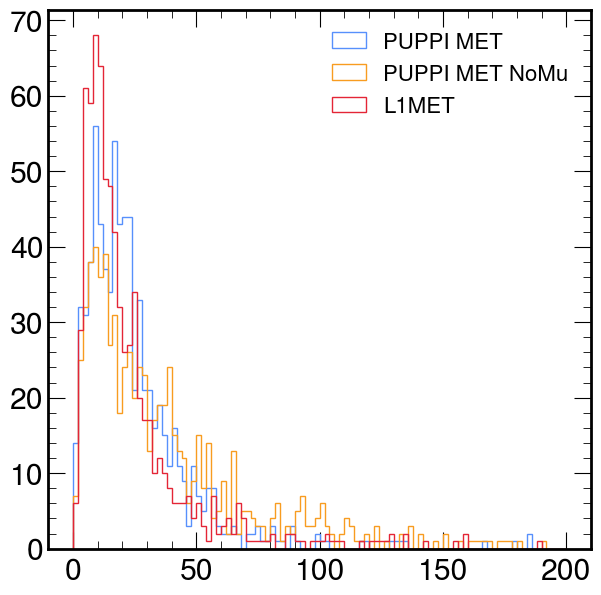

In [6]:
# plot the MET distributions
l1MET = sig_df['methf_0_pt']

if makePlots:
    plt.hist(puppiMET_df['PuppiMET_pt'], bins = 100, range = [0,200], histtype = 'step', log = False, label = "PUPPI MET")
    plt.hist(puppiMETNoMu_df['PuppiMET_pt'], bins = 100, range = [0,200], histtype = 'step',  label = "PUPPI MET NoMu")
    plt.hist(l1MET, bins = 100, range = [0,200], histtype = 'step', label = "L1MET")
    if flatSample:
      plt.hist(puppiMETNoMuUnfilt_df['PuppiMET_pt'], bins = 100, range = [0,200], histtype = 'step', label = "PUPPI MET NoMu unfiltered")
      plt.hist(l1METUnfilt_df, bins = 100, range = [0,200], histtype = 'step', label = "L1MET unfiltered")

plt.legend(fontsize=16)

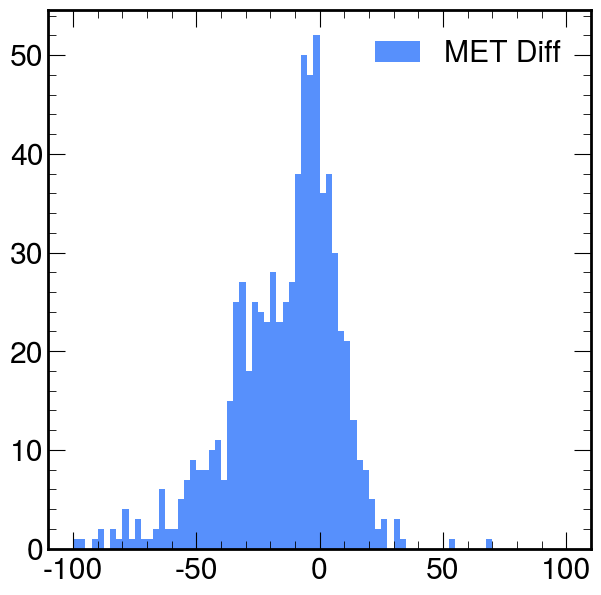

In [7]:
# plot the MET resolution
if makePlots:
    plt.hist((l1MET - puppiMETNoMu_df['PuppiMET_pt']), bins = 80, range = [-100,100], label = "MET Diff")
    plt.legend()

/Users/analogy/envs/netmet_env/lib/python3.8/site-packages/awkward/_nplikes/array_module.py:245: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


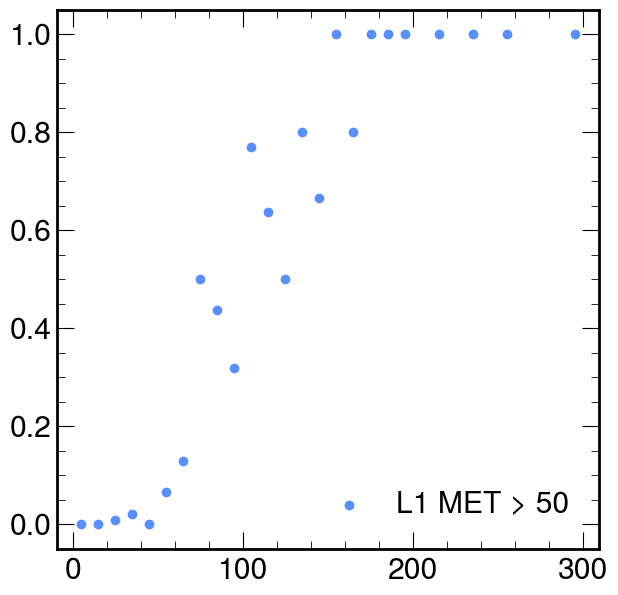

In [8]:
# plot the MET efficiency 
eff_data, xvals = plotting.efficiency(l1MET, puppiMETNoMu_df['PuppiMET_pt'], l1MetThresh, 10, 400)

if makePlots:
    plt.scatter(xvals, eff_data, label="L1 MET > " + str(l1MetThresh))
    plt.legend()

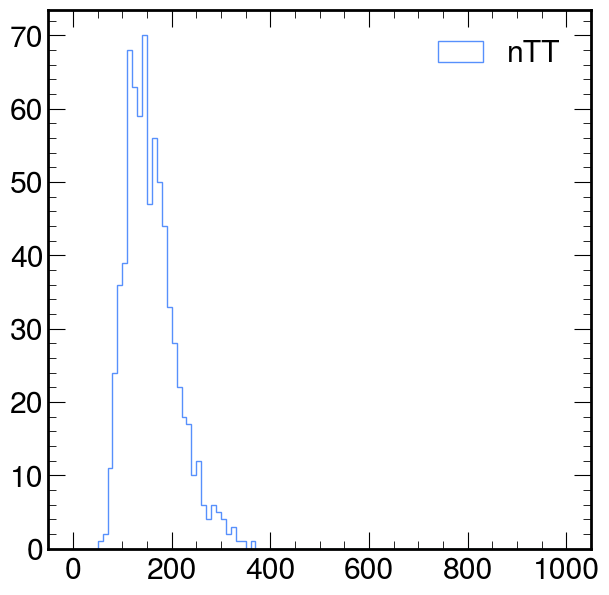

In [9]:
# get the nTT
if 'ntt' in inputSums:
    l1nTT = sig_df['ntt_0_pt']

    if makePlots and l1nTT.any() > 0:
        plt.hist(l1nTT, bins = 100, range = [0,1000], histtype = 'step', label = 'nTT')
        plt.legend()

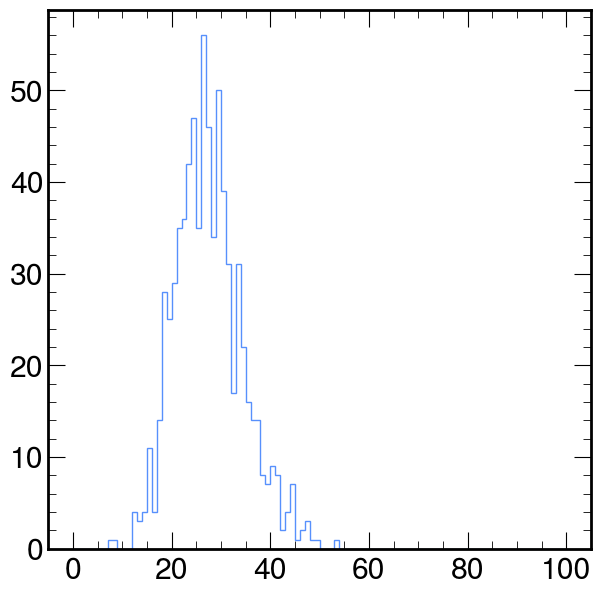

In [10]:
if makePlots:
    plt.hist(nPVs_df, bins = 100, range = [0,100], histtype = 'step', label = 'nPVsGood')

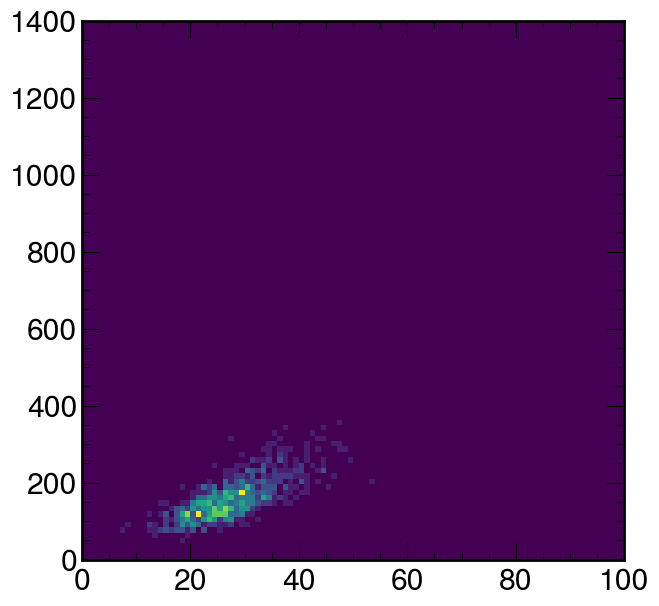

In [11]:
# plot the nTT vs reco nVtx
if 'ntt' in inputSums:
    if makePlots and l1nTT.any() > 0:
        plt.hist2d(nPVs_df.to_numpy().flatten(), ak.to_numpy(l1nTT), bins=[100, 100], range=[[0,100],[0,1400]])

In [12]:
sig_df

,Jet_0_eta,Jet_0_phi,Jet_0_pt,Jet_1_eta,Jet_1_phi,Jet_1_pt,Jet_2_eta,Jet_2_phi,Jet_2_pt,Jet_3_eta,Jet_3_phi,Jet_3_pt,methf_0_pt,ntt_0_pt
0,1.348389,0.739502,32.0,0.304504,-2.237793,22.0,0.304504,-2.498535,21.0,0.000000,0.000000,0.0,48.0,165.5
1,3.001465,2.131348,139.0,2.566406,-0.062683,84.0,1.348389,-0.845703,77.0,-0.478516,-3.020508,26.0,103.0,219.0
2,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,10.0,154.0
3,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,11.0,114.0
4,0.304504,0.391479,36.0,-1.000488,-0.236694,17.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,23.5,169.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
744,-0.043503,-0.323669,22.5,-1.522461,-1.541748,15.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,33.5,293.5
745,0.217499,0.652466,73.0,-0.739502,-1.715576,12.0,-2.000977,-2.498535,5.5,-3.001465,-2.846680,0.5,64.5,261.0
746,-1.174561,-1.889648,29.5,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,29.0,157.0
747,0.478516,1.870605,35.5,-0.043503,-0.149689,29.0,-0.217499,-0.149689,22.5,-1.609619,-1.454590,21.0,11.0,239.0


In [13]:
puppiMETNoMu_df

,PuppiMET_pt
0,54.554325
1,112.182938
2,18.004009
3,2.935682
4,5.564639
...,...
744,20.691721
745,98.386330
746,14.977434
747,33.643532


In [14]:
X = sig_df.copy()
Y = puppiMETNoMu_df.copy()
scaler = StandardScaler()

if scaleData:
	X[X.columns] = pd.DataFrame(scaler.fit_transform(X))

X_train = X.sample(frac=trainFrac, random_state=3).dropna()
Y_train = Y.loc[X_train.index]

print(X_train[:10])
print(Y_train[:10])

# define baseline model
def baseline_model(nInput):
	# create model
	model = Sequential()
	# normalize layers
	if normLayer:
		normalizer = tf.keras.layers.Normalization(input_shape=[nInput,], axis=-1)
		normalizer.adapt(X_train)
		model.add(normalizer)
	model.add(Dense(nInput*32, input_shape=(nInput,), activation='relu'))
	model.add(Dense(nInput*32, activation='relu'))
	model.add(Dense(1))
	# Compile model
	model.compile(loss='mean_absolute_percentage_error',  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))
	#model.compile(loss='huber_loss', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))
	return model


     Jet_0_eta  Jet_0_phi  Jet_0_pt  Jet_1_eta  Jet_1_phi  Jet_1_pt  \
521   0.043503   2.653320      69.0   0.000000   0.000000       0.0   
567   0.000000   0.000000       0.0   0.000000   0.000000       0.0   
634  -0.391479   2.653320      31.0  -0.739502   0.565552      20.0   
314  -0.043503   1.174561      20.0  -0.217499   0.913452      17.0   
503   0.565552   1.174561      68.5  -1.000488  -0.323669      28.0   
468   1.870605   2.827637      46.0   1.348389   2.131348      41.0   
518   3.219238   2.653320      89.5   1.435547   1.522461      46.0   
137   0.000000   0.000000       0.0   0.000000   0.000000       0.0   
273   0.000000   0.000000       0.0   0.000000   0.000000       0.0   
65    0.304504   2.740723     175.0   0.217499   2.218262      54.0   

     Jet_2_eta  Jet_2_phi  Jet_2_pt  Jet_3_eta  Jet_3_phi  Jet_3_pt  \
521   0.000000   0.000000       0.0   0.000000   0.000000       0.0   
567   0.000000   0.000000       0.0   0.000000   0.000000       0.0   
634  

In [15]:
# evaluate model with standardized dataset
if testNN:
	with tf.device(device):
		estimators = []
		estimators.append(('standardize', StandardScaler()))
		estimators.append(('mlp', KerasRegressor(model=baseline_model, epochs=10, batch_size=500, verbose=1)))
		pipeline = Pipeline(estimators)
		kfold = KFold(n_splits=5)
		results = cross_val_score(pipeline, X_train, Y, cv=kfold, scoring='neg_mean_squared_error')
		print("Standardized results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [16]:
# train final model
if trainNN:
    with tf.device(device):
        model = baseline_model(X_train.shape[1])
        model.fit(X_train, Y_train, epochs=10, batch_size=500, verbose=1)
        model.save(modelFile)

Metal device set to: AMD Radeon Pro 5300M

systemMemory: 16.00 GB
maxCacheSize: 1.99 GB



2024-06-26 17:38:57.545739: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-26 17:38:57.546666: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-26 17:38:57.546723: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-26 17:38:57.547225: I tensorflow/core/common_runtime/pluggable_device/plug

Epoch 1/10
1/1 [==============================] - 0s 457ms/step - loss: 100.2929
Epoch 2/10
1/1 [==============================] - 0s 5ms/step - loss: 76.2571
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 79.4715
Epoch 4/10
1/1 [==============================] - 0s 7ms/step - loss: 70.3469
Epoch 5/10
1/1 [==============================] - 0s 7ms/step - loss: 64.8191
Epoch 6/10
1/1 [==============================] - 0s 6ms/step - loss: 64.1423
Epoch 7/10
1/1 [==============================] - 0s 6ms/step - loss: 63.3012
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 61.7694
Epoch 9/10
1/1 [==============================] - 0s 6ms/step - loss: 59.4700
Epoch 10/10
1/1 [==============================] - 0s 6ms/step - loss: 57.9678


In [17]:
# predict values for efficiency
Xp = X.drop(X_train.index)
      
with tf.device(device):
    model = keras.models.load_model(modelFile)
    Yp = model.predict(Xp)

12/12 [==============================] - 0s 1ms/step


In [18]:
Yp

array([[ 10.797715 ],
       [118.78997  ],
       [  9.496353 ],
       [  7.968278 ],
       [  5.225483 ],
       [  8.165106 ],
       [  7.2986765],
       [  7.681883 ],
       [  6.5441008],
       [  4.6027975],
       [ 17.445316 ],
       [  9.3174095],
       [  8.446433 ],
       [ 21.23465  ],
       [ 12.804517 ],
       [ 11.479886 ],
       [  9.577807 ],
       [ 10.787801 ],
       [ 10.690075 ],
       [ 15.28335  ],
       [ 11.152858 ],
       [169.853    ],
       [  2.5120206],
       [ 43.76728  ],
       [ 14.575284 ],
       [  8.307244 ],
       [ 31.450823 ],
       [  6.218313 ],
       [  7.7149506],
       [  8.4407015],
       [ 10.772822 ],
       [ 28.250538 ],
       [127.11033  ],
       [ 17.477863 ],
       [ 27.345438 ],
       [ 11.176064 ],
       [  6.491964 ],
       [ 15.480805 ],
       [  7.29885  ],
       [ 14.19913  ],
       [  7.951468 ],
       [  7.622594 ],
       [ 11.3720455],
       [  8.230292 ],
       [  2.4148927],
       [ 1

In [19]:
# and for the rate
if doFixedRate:
    Xp_bkg = bkg_df.copy()

    if scaleData:
        Xp_bkg[Xp_bkg.columns] = pd.DataFrame(scaler.transform(Xp_bkg))

    with tf.device(device):    
        model = keras.models.load_model(modelFile)
        Yp_bkg = model.predict(Xp_bkg)

385/385 [==============================] - 0s 873us/step


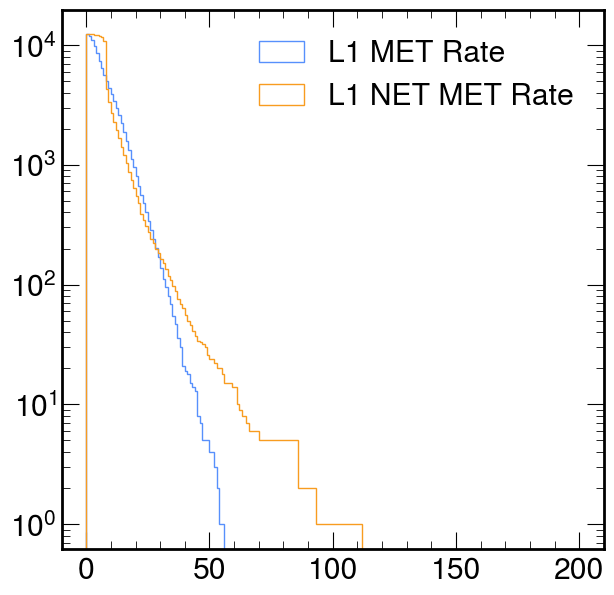

In [20]:
if doFixedRate:
    l1NetMET_bkg = Yp_bkg.flatten()
    l1MET_bkg = bkg_df['methf_0_pt']

    # rate plots must be in bins of GeV
    xrange = [0,200]
    bins = xrange[1]

    rateHist = plt.hist(l1MET_bkg, bins = bins, range = xrange, histtype = 'step', label = 'L1 MET Rate', cumulative=-1, log=True)
    rateHist_netMET = plt.hist(l1NetMET_bkg, bins = bins, range = xrange, histtype = 'step', label = 'L1 NET MET Rate', cumulative=-1, log=True)
    plt.legend()
        
    # get rate at threshold 
    l1MET_fixed_rate = rateHist[0][l1MetThresh*int((xrange[1]/bins))]
    netMET_thresh = plotting.getThreshForRate(rateHist_netMET[0], bins, l1MET_fixed_rate)

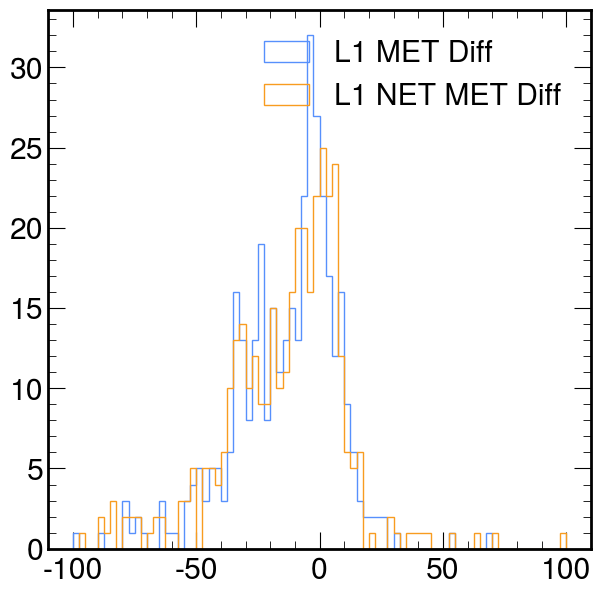

In [21]:
l1NetMET = Yp.flatten()
l1MET_test = l1MET.drop(X_train.index)
puppiMETNoMu_df_test = puppiMETNoMu_df.drop(X_train.index)

# plot the MET resolution
if makePlots:
    plt.hist((l1MET_test - puppiMETNoMu_df_test['PuppiMET_pt']), bins = 80, range = [-100,100], label = "L1 MET Diff", histtype = 'step')
    plt.hist((l1NetMET - puppiMETNoMu_df_test['PuppiMET_pt']), bins = 80, range = [-100,100], label = "L1 NET MET Diff", histtype = 'step')
    plt.legend()

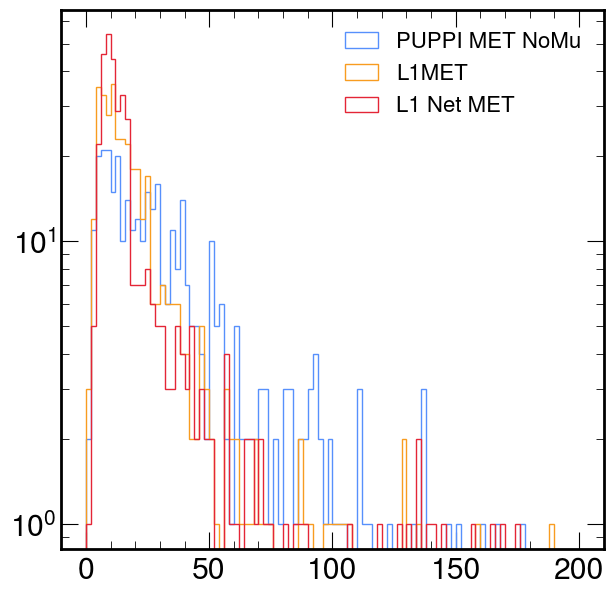

In [22]:
# plot the MET distributions
if makePlots:
    plt.hist(puppiMETNoMu_df_test['PuppiMET_pt'], bins = 100, range = [0,200], histtype = 'step',  log = True, label = "PUPPI MET NoMu")
    plt.hist(l1MET_test, bins = 100, range = [0,200], histtype = 'step', label = "L1MET")
    plt.hist(l1NetMET, bins = 100, range = [0,200], histtype = 'step', label = "L1 Net MET ")  
    plt.legend(fontsize=16)

(array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 5., 26., 16., ...,  0.,  0.,  0.],
        [ 6., 23., 26., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([  0.,   4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,
         44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,  84.,
         88.,  92.,  96., 100., 104., 108., 112., 116., 120., 124., 128.,
        132., 136., 140., 144., 148., 152., 156., 160., 164., 168., 172.,
        176., 180., 184., 188., 192., 196., 200.]),
 array([  0.,   4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,
         44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,  84.,
         88.,  92.,  96., 100., 104., 108., 112., 116., 120., 124., 128.,
        132., 136., 140., 144., 148., 152., 156., 160., 164., 168., 172.,
        176., 180., 184., 188., 192., 196., 200.]),
 <matplotlib.collec

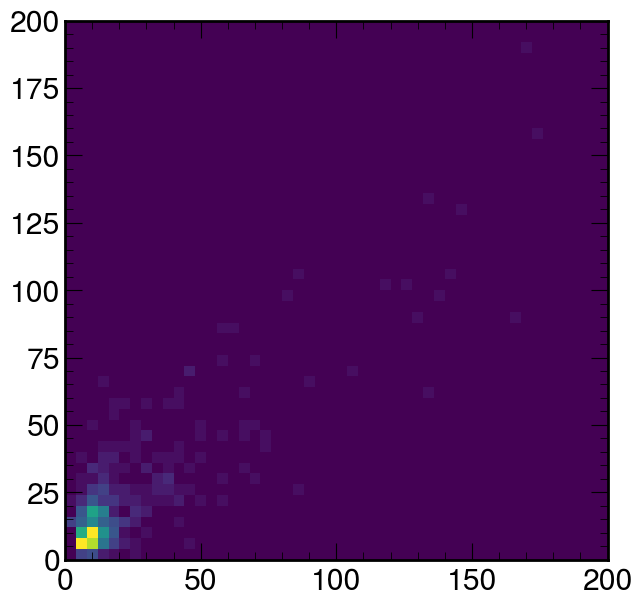

In [23]:
plt.hist2d(ak.to_numpy(ak.flatten(Yp)), l1MET_test, bins=[50, 50], range=[[puppiMETCut,200+puppiMETCut],[puppiMETCut,200+puppiMETCut]])

(array([[ 0.,  1.,  1., ...,  0.,  0.,  0.],
        [ 6., 12., 10., ...,  0.,  0.,  0.],
        [ 4., 15., 12., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([  0.,   4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,
         44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,  84.,
         88.,  92.,  96., 100., 104., 108., 112., 116., 120., 124., 128.,
        132., 136., 140., 144., 148., 152., 156., 160., 164., 168., 172.,
        176., 180., 184., 188., 192., 196., 200.]),
 array([  0.,   4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,
         44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,  84.,
         88.,  92.,  96., 100., 104., 108., 112., 116., 120., 124., 128.,
        132., 136., 140., 144., 148., 152., 156., 160., 164., 168., 172.,
        176., 180., 184., 188., 192., 196., 200.]),
 <matplotlib.collec

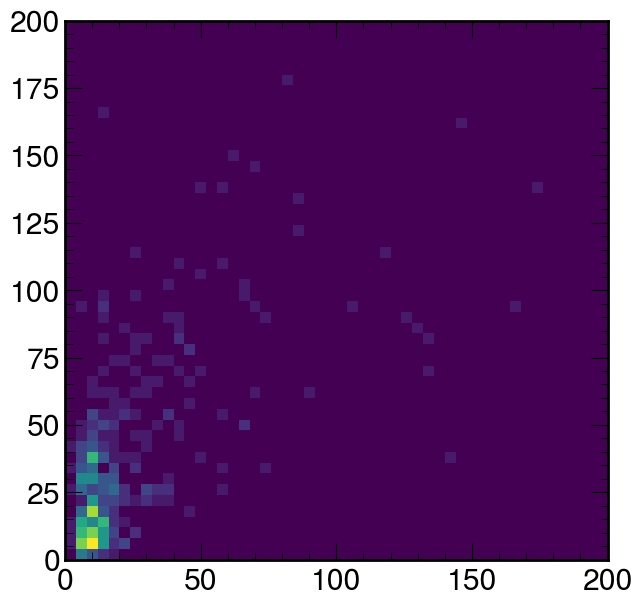

In [24]:
plt.hist2d(ak.to_numpy(ak.flatten(Yp)), ak.to_numpy(puppiMETNoMu_df_test['PuppiMET_pt']), bins=[50, 50], range=[[puppiMETCut,200+puppiMETCut],[puppiMETCut,200+puppiMETCut]])

(array([[ 2.,  5.,  2., ...,  0.,  0.,  0.],
        [ 4., 19.,  7., ...,  0.,  0.,  0.],
        [ 4.,  4.,  8., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([  0.,   4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,
         44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,  84.,
         88.,  92.,  96., 100., 104., 108., 112., 116., 120., 124., 128.,
        132., 136., 140., 144., 148., 152., 156., 160., 164., 168., 172.,
        176., 180., 184., 188., 192., 196., 200.]),
 array([  0.,   4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,
         44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,  84.,
         88.,  92.,  96., 100., 104., 108., 112., 116., 120., 124., 128.,
        132., 136., 140., 144., 148., 152., 156., 160., 164., 168., 172.,
        176., 180., 184., 188., 192., 196., 200.]),
 <matplotlib.collec

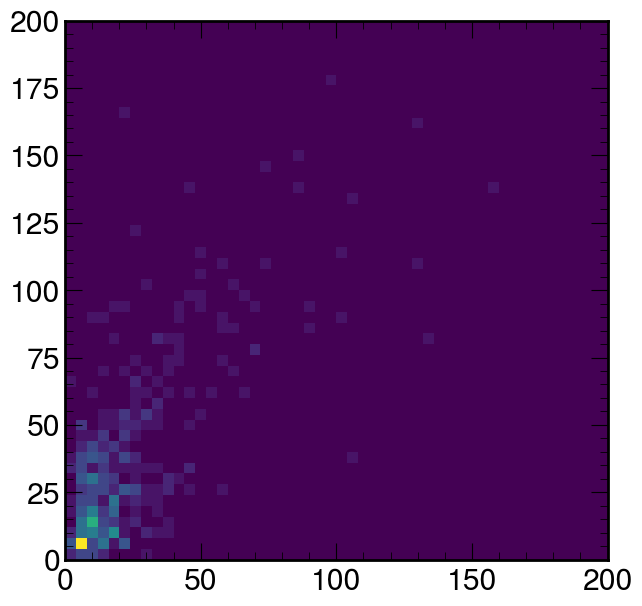

In [25]:
plt.hist2d(l1MET_test, ak.to_numpy(puppiMETNoMu_df_test['PuppiMET_pt']), bins=[50, 50], range=[[puppiMETCut,200+puppiMETCut],[puppiMETCut,200+puppiMETCut]])

/Users/analogy/envs/netmet_env/lib/python3.8/site-packages/awkward/_nplikes/array_module.py:245: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


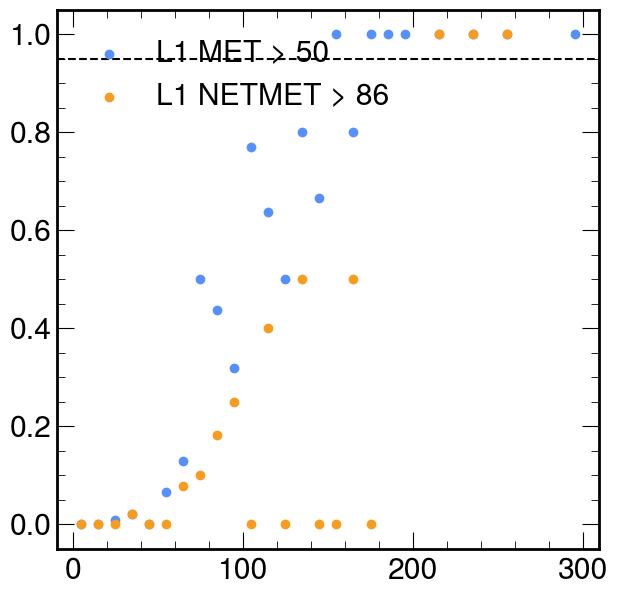

In [26]:
# plot the MET efficiency
eff_data, xvals = plotting.efficiency(l1MET, puppiMETNoMu_df['PuppiMET_pt'], l1MetThresh, 10, 400)
netMET_eff_data = plotting.efficiency(l1NetMET, puppiMETNoMu_df_test['PuppiMET_pt'], netMET_thresh, 10, 400)[0]

if makePlots:
    plt.axhline(0.95, linestyle='--', color='black')
    plt.scatter(xvals, eff_data, label="L1 MET > " + str(l1MetThresh))
    plt.scatter(xvals, netMET_eff_data, label="L1 NETMET > " + str(netMET_thresh))
    plt.legend()